In [1]:
from typing import Any, Dict, List, Optional, Tuple, Union
from os import path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import torchvision.transforms as T

import torchmetrics
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch import (
    cli_lightning_logo,
    LightningDataModule,
    LightningModule,
    Trainer,
)
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.utilities.model_summary import ModelSummary

from pytorch_grad_cam import EigenCAM, GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image

from shared_plotting import show_failures


In [2]:
EPOCHS = 7
BATCH_SIZE = 32
LEARNING_RATE = 0.003
IMAGE_SIZE = 224
TRAIN_DATA_PATH: str = path.join("..", "data", "train")
VALIDATION_DATA_PATH: str = path.join("..", "data", "val")
TEST_DATA_PATH: str = path.join("..", "data", "test")


TRAIN_TRANSFORM_IMG = T.Compose(
    [
        T.Grayscale(3),
        T.RandomRotation(degrees=10),
        T.RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.05), ratio=(1, 1)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
TEST_TRANSFORM_IMG = T.Compose(
    [
        T.Grayscale(3),
        T.Resize(IMAGE_SIZE),
        T.CenterCrop(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


In [3]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def create_model(num_classes: int = 2):
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    set_parameter_requires_grad(model, feature_extracting=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    return model


In [4]:
class Backbone(nn.Module):
    def __init__(self, num_classes: int = 2, dropout: float = 0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(16 * 1 * 1, 120),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(120, 84),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(84, num_classes),
        )

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = self.classifier(x)
        return x


In [5]:
class ImageClassifier(LightningModule):
    """
    >>> ImageClassifier(Backbone())  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    ImageClassifier(
      (backbone): ...
    )
    """

    def __init__(
        self,
        backbone: Optional[Backbone] = None,
        learning_rate: float = 0.0001,
        num_classes: int = 2,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["backbone"])
        if backbone is None:
            backbone = Backbone()
        self.model = backbone

        self.train_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
        self.val_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )
        self.test_acc = torchmetrics.Accuracy(
            task="multiclass", num_classes=num_classes
        )

    def forward(self, x):
        # use forward for inference/predictions
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("accuracy", self.test_acc)

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        x, y = batch
        return self(x)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)


In [6]:
class ImageClassificationDataModule(LightningDataModule):
    def __init__(self, batch_size: int = 32):
        super().__init__()
        self.train_dataset = torchvision.datasets.ImageFolder(
            root=TRAIN_DATA_PATH, transform=TRAIN_TRANSFORM_IMG
        )
        self.validation_dataset = torchvision.datasets.ImageFolder(
            root=VALIDATION_DATA_PATH, transform=TEST_TRANSFORM_IMG
        )
        self.test_dataset = torchvision.datasets.ImageFolder(
            root=TEST_DATA_PATH, transform=TEST_TRANSFORM_IMG
        )

        self.batch_size = batch_size

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, num_workers=4, shuffle=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.validation_dataset, batch_size=self.batch_size, num_workers=4
        )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=4)


In [7]:
trainer = Trainer(
    max_epochs=EPOCHS,
    logger=CSVLogger(save_dir="logs/", name="xnn"),
)  # , callbacks=[EarlyStopping(monitor="valid_loss", mode="min")]
data_module = ImageClassificationDataModule()
model = ImageClassifier(backbone=create_model())
summary = ModelSummary(model, max_depth=-1)
print(summary)
# model_compiled = torch.compile(model, mode="reduce-overhead")
trainer.fit(model, datamodule=data_module)
trainer.test(ckpt_path="best", datamodule=data_module)
predictions = trainer.predict(ckpt_path="best", datamodule=data_module)
print(predictions[0])


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/Caskroom/miniforge/base/envs/xnn/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/xnn/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | ResNet             | 23.5 M
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/xnn/lib/python3.11/site-packages/lightning/fabric/loggers/c

    | Name                        | Type               | Params
---------------------------------------------------------------------
0   | model                       | ResNet             | 23.5 M
1   | model.conv1                 | Conv2d             | 9.4 K 
2   | model.bn1                   | BatchNorm2d        | 128   
3   | model.relu                  | ReLU               | 0     
4   | model.maxpool               | MaxPool2d          | 0     
5   | model.layer1                | Sequential         | 215 K 
6   | model.layer1.0              | Bottleneck         | 75.0 K
7   | model.layer1.0.conv1        | Conv2d             | 4.1 K 
8   | model.layer1.0.bn1          | BatchNorm2d        | 128   
9   | model.layer1.0.conv2        | Conv2d             | 36.9 K
10  | model.layer1.0.bn2          | BatchNorm2d        | 128   
11  | model.layer1.0.conv3        | Conv2d             | 16.4 K
12  | model.layer1.0.bn3          | BatchNorm2d        | 512   
13  | model.layer1.0.relu         

/opt/homebrew/Caskroom/miniforge/base/envs/xnn/lib/python3.11/site-packages/torchmetrics/functional/classification/accuracy.py:65: UserWarning: MPS: no support for int64 reduction ops, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/ReduceOps.mm:144.)
  tp = tp.sum(dim=0 if multidim_average == "global" else 1)


Epoch 6: 100%|██████████| 163/163 [01:57<00:00,  1.39it/s, v_num=0, val_loss=0.180, val_acc=0.938, train_acc=0.997]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 6: 100%|██████████| 163/163 [01:57<00:00,  1.39it/s, v_num=0, val_loss=0.180, val_acc=0.938, train_acc=0.997]


Restoring states from the checkpoint path at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt
Loaded model weights from the checkpoint at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt


Testing DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  6.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8413461446762085     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt
Loaded model weights from the checkpoint at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt


Predicting DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  6.52it/s]
tensor([[ 0.9746, -0.7302],
        [ 3.2103, -3.0381],
        [ 2.7654, -2.6624],
        [-0.9178,  1.0539],
        [ 2.0370, -1.9385],
        [ 4.3497, -4.1398],
        [ 2.0128, -1.9312],
        [ 2.2314, -2.1449],
        [ 1.2467, -1.0248],
        [ 4.0588, -3.9444],
        [ 4.2051, -4.2428],
        [-1.5275,  1.5804],
        [ 4.1646, -4.2345],
        [ 2.0431, -2.0618],
        [-0.1633,  0.2816],
        [ 1.6798, -1.6533],
        [-4.5519,  4.2052],
        [-0.4785,  0.5440],
        [ 5.4616, -5.4909],
        [ 1.8884, -1.9144],
        [ 3.5065, -3.4770],
        [ 3.0533, -2.9609],
        [ 1.0659, -0.7993],
        [ 2.9953, -2.9961],
        [ 3.2019, -3.1722],
        [ 1.6485, -1.6438],
        [ 1.8261, -1.9541],
        [ 5.0567, -5.0744],
        [ 1.5386, -1.2744],
        [ 0.6833, -0.5578],
        [ 1.0416, -0.9815],
        [ 2.3927, -2.2501]])


In [8]:
# Evaluate model based on test_step
train_acc = trainer.test(dataloaders=data_module.train_dataloader())[0]["accuracy"]
val_acc = trainer.test(dataloaders=data_module.val_dataloader())[0]["accuracy"]
test_acc = trainer.test(dataloaders=data_module.test_dataloader())[0]["accuracy"]
print(
    f"Train Acc {train_acc*100:.2f}%"
    f" | Val Acc {val_acc*100:.2f}%"
    f" | Test Acc {test_acc*100:.2f}%"
)


/opt/homebrew/Caskroom/miniforge/base/envs/xnn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt
Loaded model weights from the checkpoint at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt
/opt/homebrew/Caskroom/miniforge/base/envs/xnn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 163/163 [00:29<00:00,  5.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.9986580014228821     │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt
Loaded model weights from the checkpoint at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │          0.9375           │
└───────────────────────────┴───────────────────────────┘

Restoring states from the checkpoint path at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt
Loaded model weights from the checkpoint at logs/xnn/version_0/checkpoints/epoch=6-step=1141.ckpt


Testing DataLoader 0: 100%|██████████| 20/20 [00:03<00:00,  6.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         accuracy          │    0.8413461446762085     │
└───────────────────────────┴───────────────────────────┘

Train Acc 99.87% | Val Acc 93.75% | Test Acc 84.13%


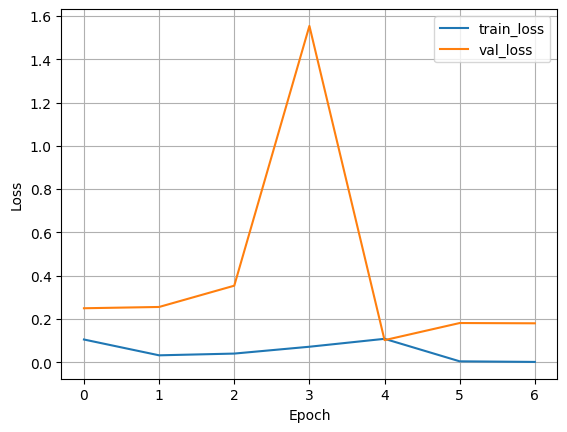

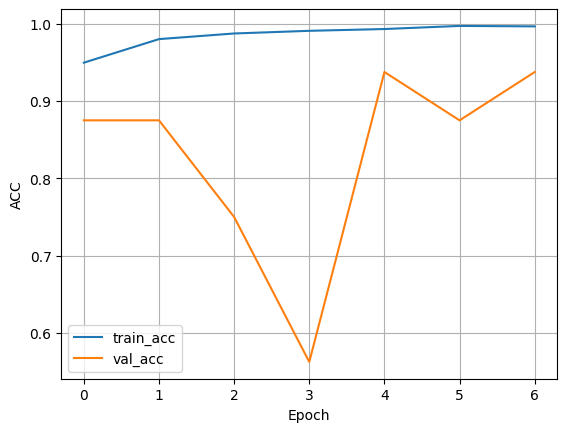

In [9]:
import pandas as pd
import matplotlib.pyplot as plt


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()


In [10]:
from PIL import Image
import cv2
import numpy as np

image_url = "../data/train/PNEUMONIA/person1308_bacteria_3292.jpeg"
img = np.array(Image.open(image_url))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = T.ToTensor()
tensor = transform(img).unsqueeze(0)

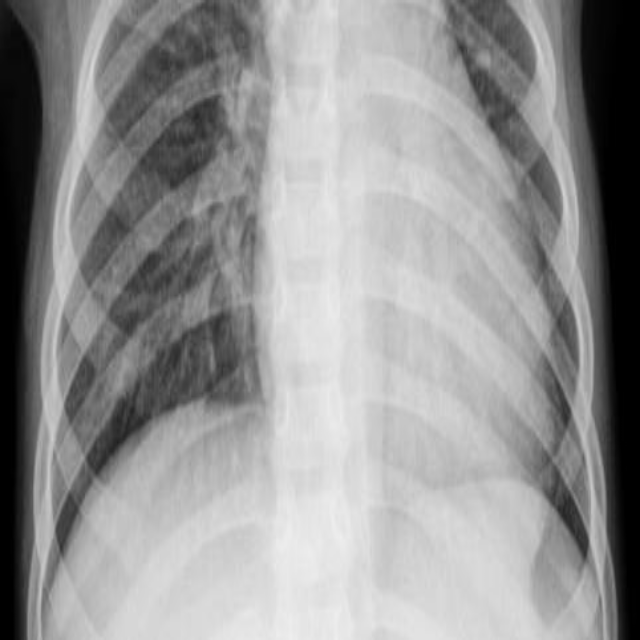

In [11]:
Image.fromarray(rgb_img, mode="RGB")

In [12]:
img.shape

(640, 640, 3)

In [13]:
model.model.layer4[-1]

Bottleneck(
  (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
)

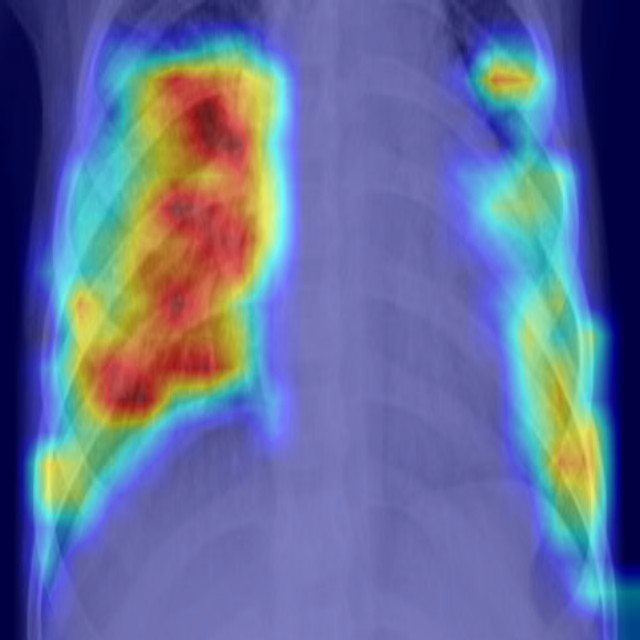

In [14]:
target_layers = [model.model.layer4[-2]]
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

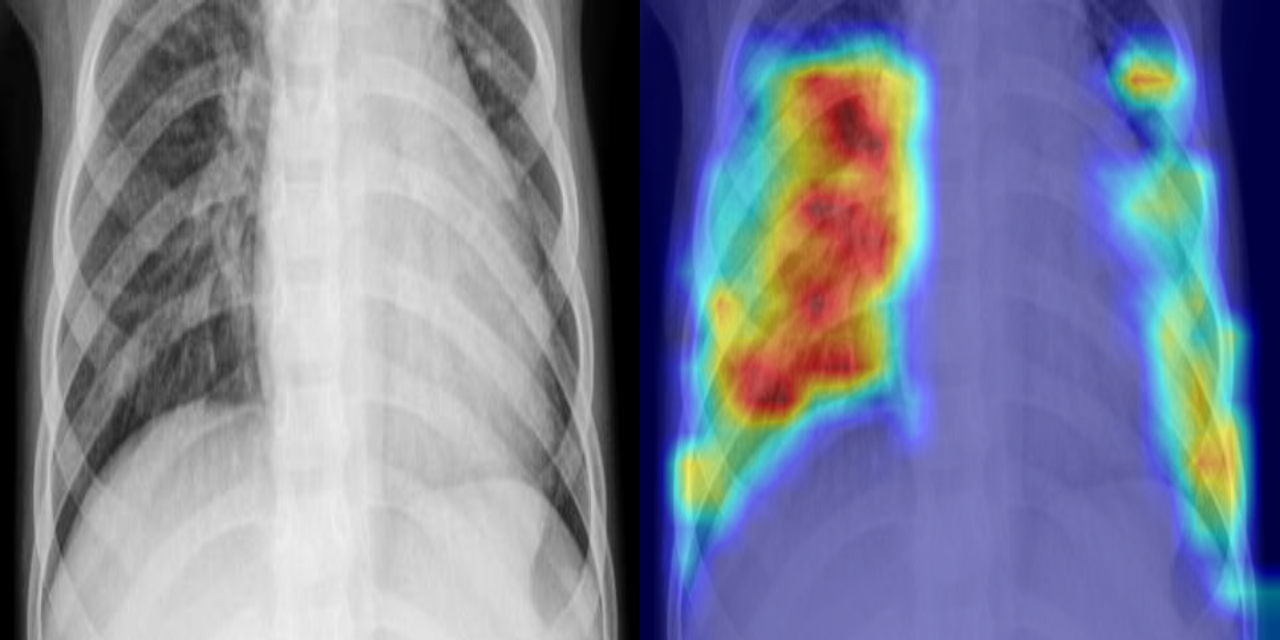

In [15]:
Image.fromarray(np.hstack((rgb_img, cam_image)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

(<Figure size 1000x2000 with 50 Axes>,
 array([[<Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>],
        [<Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>],
        [<Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>],
        [<Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
         <Axes: title={'center': 'P: 1 | T: 0'}>,
        

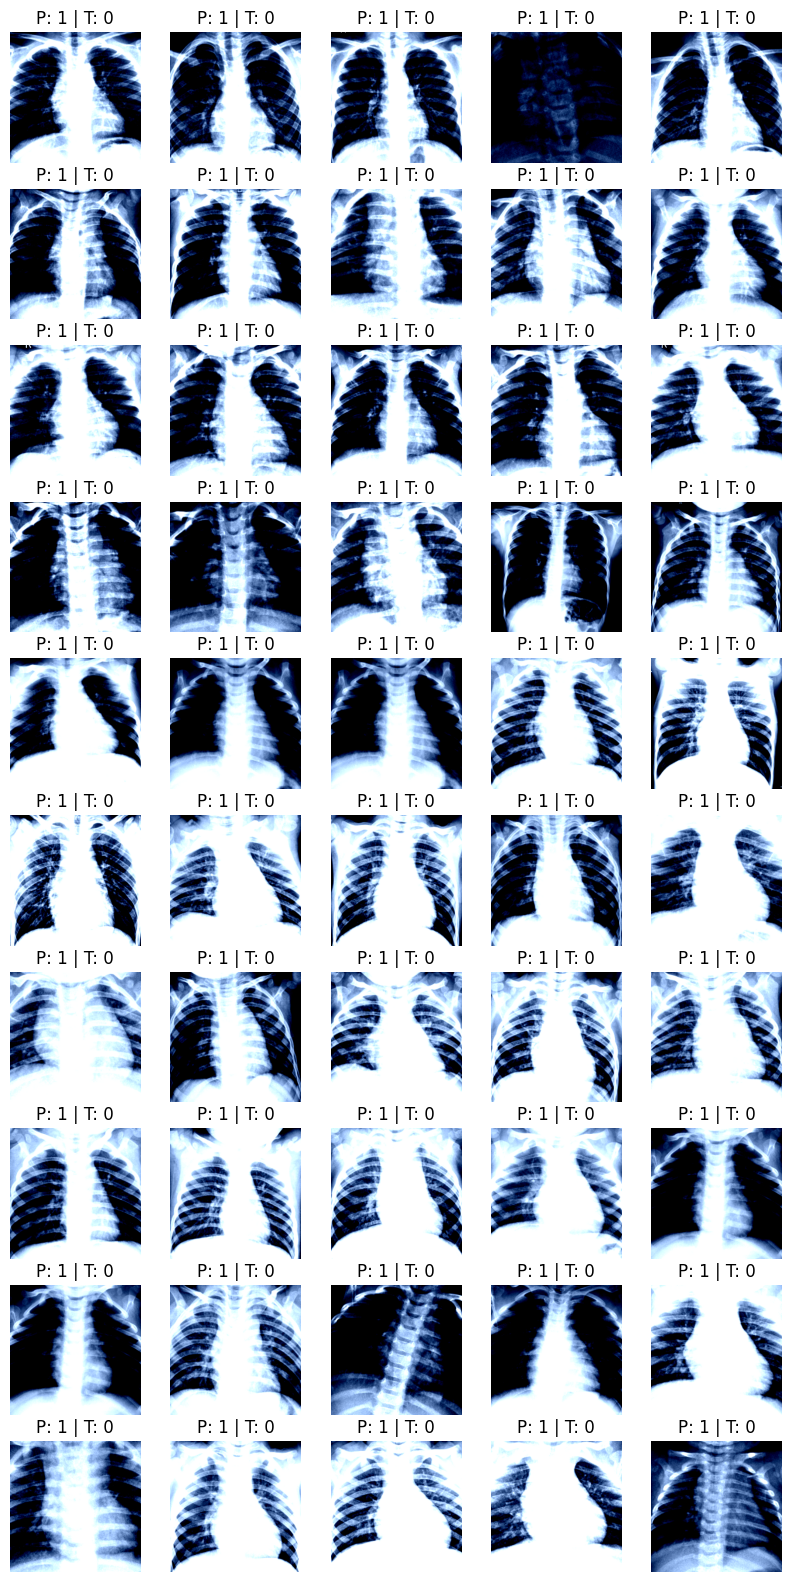

In [16]:
show_failures(model, data_module.test_dataloader(), nrows=10, ncols=5, figsize=(10, 20))
